# Warngle and Analyze Data #

In this project, we will wrangle and analyze data collected from a twitter account for rating dogs called "WeRateDogs". The data includes a text of the tweets on that twitter account in addition to other attributes such as "Id" of the tweet, the time stamp, retweet status...etc. Also there are some other fields have been extracted from the tweets text such as the rating of each dog, its name, and the stage (doggo, floofer, pupper, or puppo).


In [57]:
# load the required python libraries
import pandas as pd
import numpy as np
import json
import time
import tweepy
import logging
import re
import requests
from collections import Counter
import matplotlib.pyplot as plt
from pylab import rcParams
from skimage import io

## Gathering Data ##
This step is our first step in the data wrangling process. In this step, we gather the required data from different sources, mainly we have three sources as follows:

-  The excel file provided by Udacity and I have downloaded right away from the link on the project description page.
-  The tweets that will be queried directly from Twitter API to get more information and additional fields about the tweets using the twitter_id field from the given Excel sheet.
-  The "image-predictions.tsv" file that includes the images' predictions and we have to get and download its content from the given URL through a direct web request call.


In [58]:
logging.basicConfig(filename="logs.txt", level=logging.INFO)
%matplotlib inline

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

tweets_archive_df = pd.read_csv('./twitter-archive-enhanced.csv')

In [59]:
tweet_Ids = list(tweets_archive_df['tweet_id'])

missing_tweets_count = 0

with open('tweet_json.txt', 'w') as outfile:
    for tweetId in tweet_Ids:
        try:
            start = time.time()
            tweet = api.get_status(tweetId, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
            end = time.time()
            elapsedTime = (end - start)
            logging.info("Tweet with Id: %s has been queried in %s"% (tweetId, elapsedTime))
        except tweepy.TweepError:
            logging.error("Tweet with Id: %s doesn't exist"% tweetId)
            missing_tweets_count += 1
            continue

In [60]:
# display the first few rows of the tweets archive data frame

tweets_archive_df.head(n=10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [61]:
# read the tweets from the json formatted file that we have queried from Twitter API

tweets_df = pd.read_json('./tweet_json.txt', lines=True)

In [62]:
# Download the image predictions file

prediction_file_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(prediction_file_url)

# Save the response content to a tab-separated (tsv) file on our current root folder
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)

# Read and display the image predictions file content
img_predictions_df = pd.read_table('./image_predictions.tsv', sep='\t')
img_predictions_df.head(n=10)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


## Assessing Data #


In [63]:
tweets_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [64]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341 entries, 0 to 2340
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2341 non-null datetime64[ns]
display_text_range               2341 non-null object
entities                         2341 non-null object
extended_entities                2067 non-null object
favorite_count                   2341 non-null int64
favorited                        2341 non-null bool
full_text                        2341 non-null object
geo                              0 non-null float64
id                               2341 non-null int64
id_str                           2341 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [65]:
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## Finding out Quality and Tidiness issues ##

Let's start with **the quality issues**. After exploring the data, I have found the following quality issues:

-  **In "tweets_archive_df" dataframe:**, we have the following quality issues:
    -  There are rows in "tweets_archive_df" dataframe that represent retweets, not original tweets, so these rows should be deleted because they're not original tweets. As indicated above from "retweeted_status_id" field, there are 181 rows in "tweets_archive_df" dataframe are retweets and they will be removed.

    -  Some of dog names in "name" field are missing or mislabeled. The reasons for this issue is either due to the dog name was not mentioned in the tweet text itself, or due to a problem in the pattern or the way used to extract the dog name from the text. That is why we found "None" in the "name" field in some cases and also wrong names such as "a, all, an, such, just, O, quite, not, one...etc." in some other cases.
    
    -  If the dog name in the "text" field consists of multiple words, it will be labeled incorrectly (mislabeled) in the "name" field.
    -  There are some unwanted columns in this dataframe that need to be dropped or removed as they're not important for our analysis task.
    -  There are 23 records where the "rating_denominator" field has values other than 10, such as "0, 2, 7, 11, 12, 150, 170...etc.". These numbers are wrong because the rating denominator should be always "10". The root cause of this issue is either wrong extraction from the tweet text, or wrong rating given by the user who wrote this tweet.
    

-  **In "tweets_df" dataframe:**, we have the following quality issues:
    -  "id" field needs to be renamed to "tweet_id" to match the other two dataframes.
    -  There are many unwanted columns should be excluded (dropped), as they're not important for our analysis task.
    -  There are rows in "tweets_df" dataframe which are also retweets and need to be removed from the dataframe as they're not original ones. As inicated above from "retweeted_status" field, there are 167 rows or observations in "tweets_df" dataframe are retweets and they will be also removed.

-  **In "img_predictions_df" dataframe:**, we have the following quality issues:
    -  Remove "_"_ underscore from the dog breed fields "p1, p2, p3" to make the breed name more readable and consistent.
    -  Some of values in "p1, p2, p3" columns start with capital letters and others with small letters, we need to make these values more consistent.
    
    
Now let's explore some of **the tidiness issues** in the data. 

-  **In "tweets_archive_df" dataframe:**, we have the following issues:
    -  "timestamp" field need to be splitted into two fields, date field and time field.
    -  The "doggo, floofer, pupper, puppo" fields will be combined into one field, let's call it "stage" field. The reason for that is to have a real variable rather than values in the header.
    -  Drop unwanted columns, then re-order the desired remaining columns in more logical sense.
    -  The rating fields "rating_numerator & rating_denominator" need to be float, not integers.
    
-  **In "tweets_df" dataframe:**, we have the following quality issues:
    -  Drop unwanted columns, then re-order the desired remaining columns in more logical sense to be more readable.  
    

## Cleaning Data ##

In [66]:
# Detecting the rows that represnt retweets in the "tweets_archive_df" dataframe

retweets_df = tweets_archive_df[tweets_archive_df['retweeted_status_id'].notnull() == True]
retweets_df.shape

(181, 17)

As shown in the above cell, there are 181 rows in this dataframe need to be dropped, because they are retweets. So let's remove these rows.

In [67]:
tweets_archive_df = tweets_archive_df[tweets_archive_df['retweeted_status_id'].notnull() == False]

tweets_archive_df.shape

(2175, 17)

In [68]:
# let's check this dataframe after the last operation

tweets_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

As we can notice, the retweets have been removed and the "retweeted_status_id" field has no longer values for the remaining records.

Now let's fix the "name" field issues. As explained earlier, there are some rows that have mislabeled dog name in the "name" field. In the following code cell, I will list these common wrong values and replace them with "None" or the correct value. 

In [69]:
wrong_names = ['a', 'all', 'an', 'such', 'just', 'O', 'quite', 'not', 'one', 'by', 'his', 'infuriating', 'my', 'mad', 
               'very', 'this', 'unacceptable', 'old', 'officially', 'the']

def replaceWrongNames(name):
    if name in wrong_names:
        if name != 'O':
            return None
        else:
            return "O'Malley"
    return name
        
tweets_archive_df['name'] = tweets_archive_df['name'].apply(lambda name: replaceWrongNames(name))

tweets_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Now let's combine the dog stages into one single column, let's call it "stage" field. The following code cell will do that part by looking up the value from the current dog stages fields and map them to the new "stage" field.

In [70]:
dog_stages = ['doggo', 'floofer','pupper','puppo']

def mapDogStages(stage):
    for item in dog_stages:
        if item in stage:
            return item
    return None

tweets_archive_df['stage'] = tweets_archive_df[dog_stages].apply(lambda s: ','.join(s), axis=1).apply(lambda s: mapDogStages(s))

tweets_archive_df.head(n=10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None,doggo


Convert the "timestamp" field to datetime format to be easier for further processing.

In [71]:
tweets_archive_df['timestamp'] = pd.to_datetime(tweets_archive_df['timestamp'])

# Check the format of the field after converting its data type

print(type(tweets_archive_df['timestamp'].iloc[0]))

tweets_archive_df.info()

<class 'pandas._libs.tslib.Timestamp'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2079 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-nul

Split the "timestamp" field into two separate fields, one for date and another for time.

In [72]:
tweets_archive_df['date'] = [d.date() for d in tweets_archive_df['timestamp']]

tweets_archive_df['time'] = [d.time() for d in tweets_archive_df['timestamp']]

tweets_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,date,time
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,None,2017-08-01,16:23:56
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,None,2017-08-01,00:17:27
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,None,2017-07-31,00:18:03
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,None,2017-07-30,15:58:51
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,None,2017-07-29,16:00:24


Convert the data type of the "rating_numerator" field and "rating_denominator" field from integer to float. 

In [73]:
tweets_archive_df['rating_numerator'] = tweets_archive_df['rating_numerator'].astype('float64')

tweets_archive_df['rating_denominator'] = tweets_archive_df['rating_denominator'].astype('float64')

tweets_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null float64
rating_denominator            2175 non-null float64
name                          2079 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
stage                     

I noticed after running the code cell in above that the new "date" and "time" fields are object (string) type, so I will cast these two fields to be datetime format also as we did with the "timestamp" field previously.

In [74]:
tweets_archive_df['date'] = pd.to_datetime(tweets_archive_df['date']).dt.strftime('%m-%d-%Y')
tweets_archive_df['date'] = pd.to_datetime(tweets_archive_df['date'])

tweets_archive_df['time'] = pd.to_datetime(tweets_archive_df['time'], format= '%H:%M:%S').dt.time

print(type(tweets_archive_df['date'].iloc[0]))
print(type(tweets_archive_df['time'].iloc[0]))

tweets_archive_df.info()

<class 'pandas._libs.tslib.Timestamp'>
<class 'datetime.time'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null float64
rating_denominator            2175 non-null float64
name                          2079 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo         

In [75]:
tweets_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,date,time
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None,None,2017-08-01,16:23:56
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None,None,2017-08-01,00:17:27
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None,None,2017-07-31,00:18:03
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,None,None,None,2017-07-30,15:58:51
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,None,None,None,2017-07-29,16:00:24


Now I will remove or drop the unwanted columns from "tweets_archive_df" dataframe, becuase theses columns are no longer needed in our analysis task.

In [76]:
archive_desired_columns = ['tweet_id', 'name', 'stage', 'rating_numerator', 'rating_denominator', 'date', 'time']

tweets_archive_df = tweets_archive_df[archive_desired_columns]

tweets_archive_df.head()

,tweet_id,name,stage,rating_numerator,rating_denominator,date,time
0,892420643555336193,Phineas,None,13.0,10.0,2017-08-01,16:23:56
1,892177421306343426,Tilly,None,13.0,10.0,2017-08-01,00:17:27
2,891815181378084864,Archie,None,12.0,10.0,2017-07-31,00:18:03
3,891689557279858688,Darla,None,13.0,10.0,2017-07-30,15:58:51
4,891327558926688256,Franklin,None,12.0,10.0,2017-07-29,16:00:24


We need also to do some cleaning on the "tweets_df" dataframe to fix some of the quality and tidiness issues. 
As discussed above, there are retweets in the records need to be removed, so let's find out the retweets, then drop them from the "tweets_df" dataframe. Mainly if "retweeted_status" field has value, this means it is a retweet, otherwise it's original tweet. 

In [77]:
tweets_df[tweets_df['retweeted_status'].notnull() == True]


,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
31,NaN,NaN,2017-07-15 02:45:48,"[0, 50]","{'hashtags': [{'text': 'BATP', 'indices': [21,...",NaN,0,False,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,NaN,...,NaN,8.860534e+17,8.860534e+17,"{'url': 'https://t.co/WxwJmvjfxo', 'expanded':...",104,False,{'created_at': 'Sat Jul 15 02:44:07 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
35,NaN,NaN,2017-07-13 01:35:06,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 830583314243268608, 'id_str'...",0,False,RT @dog_rates: This is Lilly. She just paralle...,NaN,...,NaN,NaN,NaN,NaN,18399,False,{'created_at': 'Sun Feb 12 01:04:29 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
67,NaN,NaN,2017-06-26 00:13:58,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: This is Emmy. She was adopted t...,NaN,...,NaN,NaN,NaN,NaN,6772,False,{'created_at': 'Fri Jun 23 01:10:23 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
72,NaN,NaN,2017-06-24 00:09:53,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: Meet Shadow. In an attempt to r...,NaN,...,NaN,NaN,NaN,NaN,1280,False,{'created_at': 'Fri Jun 23 16:00:04 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
73,NaN,NaN,2017-06-23 18:17:33,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: Meet Terrance. He's being yelle...,NaN,...,NaN,NaN,NaN,NaN,6602,False,{'created_at': 'Tue Nov 24 03:51:38 +0000 2015...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
77,NaN,NaN,2017-06-21 19:36:23,"[0, 122]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 876850756556607488, 'id_str'...",0,False,RT @rachel2195: @dog_rates the boyfriend and h...,NaN,...,NaN,NaN,NaN,NaN,80,False,{'created_at': 'Mon Jun 19 17:14:49 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
90,NaN,NaN,2017-06-13 01:14:41,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: This is Coco. At first I though...,NaN,...,NaN,NaN,NaN,NaN,14679,False,{'created_at': 'Sun May 21 16:48:45 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
95,NaN,NaN,2017-06-10 00:35:19,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: This is Sierra. She's one preci...,NaN,...,NaN,NaN,NaN,NaN,1584,False,{'created_at': 'Fri Jun 09 16:22:42 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
106,NaN,NaN,2017-06-04 00:46:17,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: This is Dawn. She's just checki...,NaN,...,NaN,NaN,NaN,NaN,5714,False,{'created_at': 'Mon Mar 13 00:02:39 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
120,NaN,NaN,2017-05-28 01:26:04,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: Say hello to Cooper. His expres...,NaN,...,NaN,NaN,NaN,NaN,2117,False,{'created_at': 'Sat May 27 19:39:34 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


From the code cell above, there are 167 records are retweets, so let's drop them in the following code cell.

In [78]:
tweets_df = tweets_df[tweets_df['retweeted_status'].notnull() == False]
print(tweets_df.shape)

(2174, 32)


In the "tweets_df" dataframe, I will rename "id" field to be "tweet_id" to match the other two dataframes. This field is the key field that we wil merge based on when it comes to merging the dataframes after finishing our cleansing operations.

In [79]:
# rename "id" field to "tweet_id" to be consistent with the other dataframes
tweets_df.rename(columns={'id': 'tweet_id'}, inplace=True)

# check if the renaming of this field has been done as expected on the dataframe
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 0 to 2340
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2174 non-null datetime64[ns]
display_text_range               2174 non-null object
entities                         2174 non-null object
extended_entities                1993 non-null object
favorite_count                   2174 non-null int64
favorited                        2174 non-null bool
full_text                        2174 non-null object
geo                              0 non-null float64
tweet_id                         2174 non-null int64
id_str                           2174 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

I will drop the unwanted columns from "tweets_df" dataframe as they're no longer used in the current analysis task.

In [80]:
# print the columns of the dataframe to check which columns to drop
tweets_df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'tweet_id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'truncated', 'user'],
      dtype='object')

In [81]:
tweets_desired_cols = ['tweet_id', 'full_text', 'favorite_count', 'retweet_count']

tweets_df = tweets_df[tweets_desired_cols]

tweets_df.head()

,tweet_id,full_text,favorite_count,retweet_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,38331,8417
1,892177421306343426,This is Tilly. She's just checking pup on you....,32855,6206
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,24745,4105
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,41671,8544
4,891327558926688256,This is Franklin. He would like you to stop ca...,39848,9270


I will do some cleanising on the third dataframe "img_predictions_df". We have few things to do to make this dataframe ready. I will start with removing the "underscore" from the dog bread values in "p1 & p2 & p3" columns, to make values more readable.

In [82]:
img_predictions_df['p1'] = img_predictions_df['p1'].str.replace('_', ' ')
img_predictions_df['p2'] = img_predictions_df['p2'].str.replace('_', ' ')
img_predictions_df['p3'] = img_predictions_df['p3'].str.replace('_', ' ')

img_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


For the sake of consistency and readability, I will format the string values of "p1 & p2 & p3" fields to be similar using "title()" function to make the first letter of each word capital.

In [83]:
img_predictions_df['p1'] = img_predictions_df['p1'].str.title()
img_predictions_df['p2'] = img_predictions_df['p2'].str.title()
img_predictions_df['p3'] = img_predictions_df['p3'].str.title()

img_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Finally, I will merge the dataframes together based on "tweet_id" field to get the final clean dataframe. 

In [84]:
combined_tweets_df = tweets_archive_df.merge(tweets_df, on='tweet_id', how='inner')

combined_tweets_df = combined_tweets_df.merge(img_predictions_df, on='tweet_id', how='inner')

print(combined_tweets_df.shape)

combined_tweets_df.head()

(1993, 21)


,tweet_id,name,stage,rating_numerator,rating_denominator,date,time,full_text,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,Phineas,None,13.0,10.0,2017-08-01,16:23:56,This is Phineas. He's a mystical boy. Only eve...,38331,8417,...,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,Tilly,None,13.0,10.0,2017-08-01,00:17:27,This is Tilly. She's just checking pup on you....,32855,6206,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,Archie,None,12.0,10.0,2017-07-31,00:18:03,This is Archie. He is a rare Norwegian Pouncin...,24745,4105,...,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,Darla,None,13.0,10.0,2017-07-30,15:58:51,This is Darla. She commenced a snooze mid meal...,41671,8544,...,1,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,Franklin,None,12.0,10.0,2017-07-29,16:00:24,This is Franklin. He would like you to stop ca...,39848,9270,...,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True


## Storing, analyzing, and visualizing the wrangled data ##

In this stage, we will start with storing the final combined dataframe "combined_tweets_df" which represnts our clean wrangled data. I will save this dataframe in a csv file called "twitter_archive_master.csv" as requested in the project requirements.

In [85]:
# save the final clean dataframe to a csv file.

combined_tweets_df.to_csv('./twitter_archive_master.csv', index=False)

**Now let's start the analysis on the final data by loading again the master csv file into a dataframe**

In [86]:
# load the data again from the "twitter_archive_master.csv" file into a new dataframe

clean_master_df = pd.read_csv('./twitter_archive_master.csv')

clean_master_df.head()

,tweet_id,name,stage,rating_numerator,rating_denominator,date,time,full_text,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,Phineas,NaN,13.0,10.0,2017-08-01,16:23:56,This is Phineas. He's a mystical boy. Only eve...,38331,8417,...,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,Tilly,NaN,13.0,10.0,2017-08-01,00:17:27,This is Tilly. She's just checking pup on you....,32855,6206,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,Archie,NaN,12.0,10.0,2017-07-31,00:18:03,This is Archie. He is a rare Norwegian Pouncin...,24745,4105,...,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,Darla,NaN,13.0,10.0,2017-07-30,15:58:51,This is Darla. She commenced a snooze mid meal...,41671,8544,...,1,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,Franklin,NaN,12.0,10.0,2017-07-29,16:00:24,This is Franklin. He would like you to stop ca...,39848,9270,...,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True


In [87]:
# I will invoke "describe()" function on the dataframe to get quick descriptive statistics on our dataset

clean_master_df.describe()

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,1.993000e+03,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1.993000e+03,1.993000e+03
mean,7.358417e+17,12.280983,10.532363,8794.240843,2681.095334,1.203211,0.593937,1.343498e-01,6.025022e-02
std,6.749387e+16,41.508132,7.322538,12851.122871,4764.388379,0.560899,0.272022,1.006579e-01,5.090338e-02
min,6.660209e+17,0.000000,2.000000,80.000000,12.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.758457e+17,10.000000,10.000000,1897.000000,597.000000,1.000000,0.362835,5.390140e-02,1.619070e-02
50%,7.084699e+17,11.000000,10.000000,3988.000000,1290.000000,1.000000,0.587507,1.174020e-01,4.948690e-02
75%,7.878106e+17,12.000000,10.000000,10990.000000,3072.000000,1.000000,0.846628,1.948970e-01,9.160200e-02
max,8.924206e+17,1776.000000,170.000000,165056.000000,84452.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


Given the above summary table, we can conclude the following points about the dataset:

-  The total number of observations in the dataset is 1993 rows.
-  The mean or average of the favorites count (likes) is 8794.24, the median is 3988, and the maximum is 165056
-  The mean or average of the rating is 12.28/10.53, the median rating is 11/10, and the maximum is 1776 (this maximum is appearantely an outlier in the data).
-  The mean or average of the reweets count is 2681.1, the median value is 1290, and the maximum is 84452
-  The average number of images with each tweet is one image, median value is also one image, and the maximum is 4
-  The mean or average value of the confidence level of the first most likely prediction is about 0.59 (59%) and the median is very close to the average 0.587 (58.7%)


In [88]:
# We have noticed after merging the dataframes that there are some values in the "name" field which is "NaN", so we will find
# out these records and replace with "None".

print('Number of records that have "NaN" values is: %i'% (clean_master_df[clean_master_df['name'].isnull()].shape[0]))

clean_master_df.fillna(value=None, method='ffill', inplace=True)

clean_master_df[clean_master_df['name'].isnull()]

Number of records that have "NaN" values is: 92


,tweet_id,name,stage,rating_numerator,rating_denominator,date,time,full_text,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [89]:
# find out the most common dog names in the dataset

Counter(clean_master_df['name']).most_common(10)

[('None', 583),
 ('Oliver', 12),
 ('Cooper', 10),
 ('Charlie', 10),
 ('Lucy', 10),
 ('Penny', 9),
 ('Tucker', 9),
 ('Daisy', 8),
 ('Sadie', 8),
 ('Winston', 8)]

**The most common dog names are shown above ('Oliver', 12), ('Cooper', 10), ('Charlie', 10), ('Lucy', 10), ('Penny', 9), ('Tucker', 9), ('Daisy', 8), ('Sadie', 8), ('Winston', 8).**

**So the most famous name for the dogs in our dataset is "Oliver"**.

In [90]:
# Let's explore the dogs that have the highest favorite count (most liked dogs) based on the "favorite_count" variable

# first, we will get the highest 10 values for the favorite count in our dataset

top_10_favorite_count = clean_master_df['favorite_count'].nlargest(10, keep='first')

most_liked_dogs_df = clean_master_df[clean_master_df['favorite_count'].isin(top_10_favorite_count)]

most_liked_dogs_df = most_liked_dogs_df.sort_values(by=['favorite_count'], ascending=False)

most_liked_dogs_df

,tweet_id,name,stage,rating_numerator,rating_denominator,date,time,full_text,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
774,744234799360020481,None,doggo,13.0,10.0,2016-06-18,18:26:18,Here's a doggo realizing you can stand in a po...,165056,84452,...,1,Labrador Retriever,0.825333,True,Ice Bear,0.044681,False,Whippet,0.018442,True
309,822872901745569793,None,puppo,13.0,10.0,2017-01-21,18:26:02,Here's a super supportive puppo participating ...,141536,48220,...,1,Lakeland Terrier,0.196015,True,Labrador Retriever,0.160329,True,Irish Terrier,0.069126,True
108,866450705531457537,Jamesy,pupper,13.0,10.0,2017-05-22,00:28:40,This is Jamesy. He gives a kiss to every other...,122851,35794,...,2,French Bulldog,0.905334,True,Boston Bull,0.078060,True,Pug,0.001771,True
809,739238157791694849,None,doggo,13.0,10.0,2016-06-04,23:31:25,Here's a doggo blowing bubbles. It's downright...,122244,62617,...,1,Eskimo Dog,0.503372,True,Siberian Husky,0.390413,True,Malamute,0.080901,True
400,807106840509214720,Stephan,pupper,13.0,10.0,2016-12-09,06:17:20,This is Stephan. He just wants to help. 13/10 ...,121479,60076,...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,Toy Terrier,0.077008,True
58,879415818425184262,Duddles,pupper,13.0,10.0,2017-06-26,19:07:24,This is Duddles. He did an attempt. 13/10 some...,104754,43816,...,1,English Springer,0.383404,True,Boston Bull,0.134967,True,Cardigan,0.110481,True
333,819004803107983360,Bo,doggo,14.0,10.0,2017-01-11,02:15:36,This is Bo. He was a very good First Doggo. 14...,92590,40390,...,1,Standard Poodle,0.351308,True,Toy Poodle,0.271929,True,Tibetan Terrier,0.094759,True
135,859196978902773760,None,puppo,12.0,10.0,2017-05-02,00:04:57,We only rate dogs. This is quite clearly a smo...,91408,31112,...,1,Angora,0.224218,False,Malamute,0.216163,True,Persian Cat,0.128383,False
93,870374049280663552,Zoey,doggo,13.0,10.0,2017-06-01,20:18:38,This is Zoey. She really likes the planet. Wou...,82462,26348,...,1,Golden Retriever,0.841001,True,Great Pyrenees,0.099278,True,Labrador Retriever,0.032621,True
1423,678399652199309312,None,pupper,12.0,10.0,2015-12-20,02:20:55,This made my day. 12/10 please enjoy https://t...,81066,33746,...,1,Swing,0.929196,False,Bedlington Terrier,0.015047,True,Great Pyrenees,0.014039,True


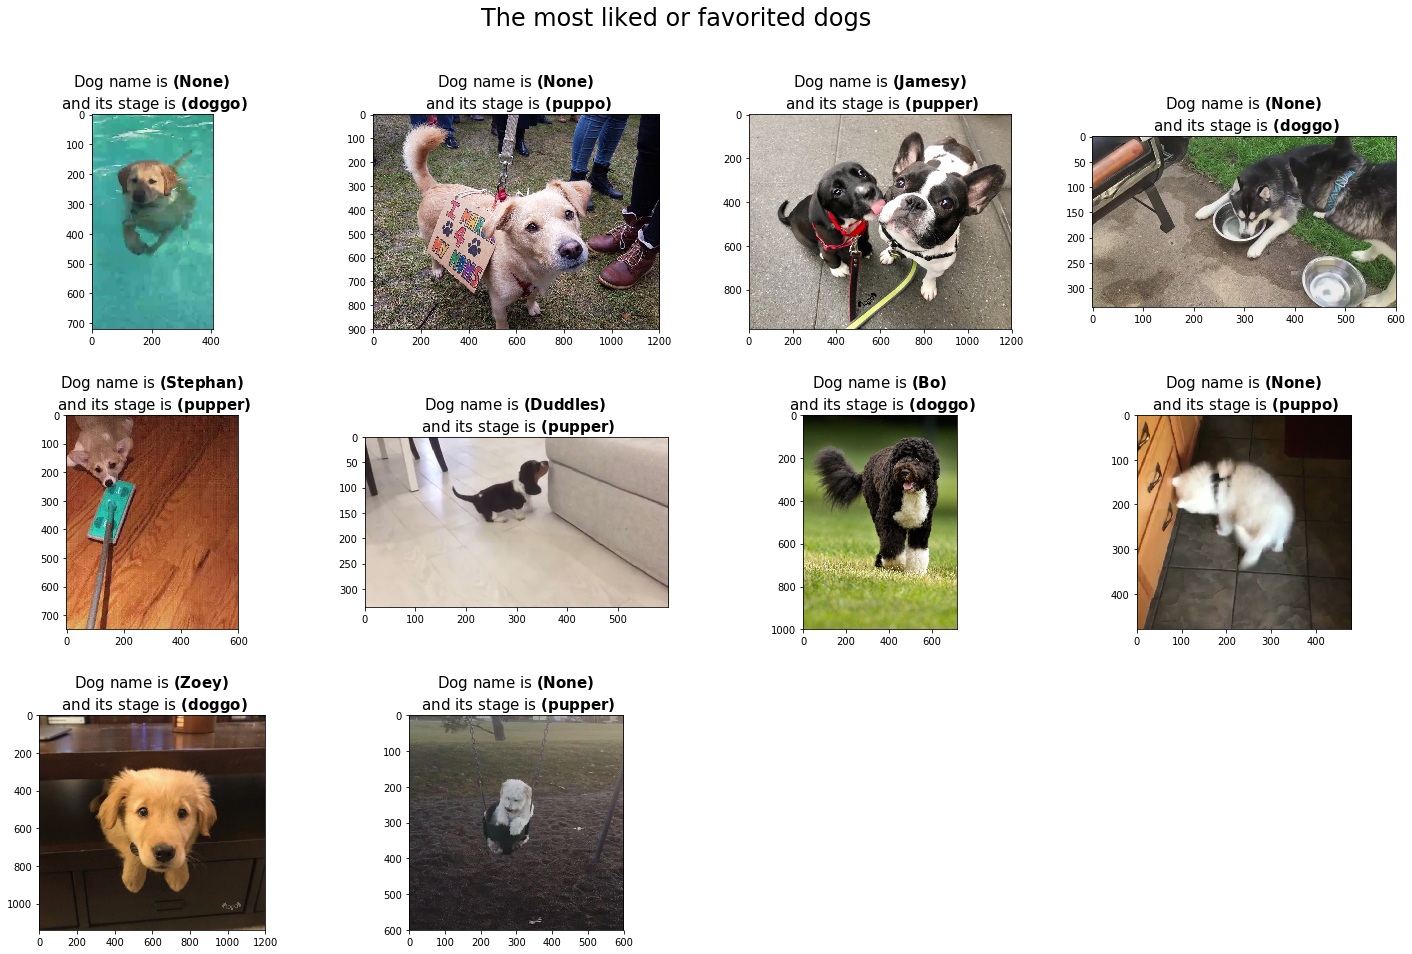

In [91]:
# Now let's see how the most liked dogs look like by visualizing or plotting their images.

fig = plt.figure(figsize=(25,15))
fig.suptitle("The most liked or favorited dogs", fontsize=24)
columns = 4
idx = 0
fig.subplots_adjust(hspace=0.4)

for i, row in most_liked_dogs_df.iterrows():
    img_url = row['jpg_url']
    dog_desc = 'Dog name is '+ r"$\bf{("+ row['name'] + ')}$ \n and its stage is '+ r"$\bf{("+ str(row['stage']) +')}$'
    image = io.imread(img_url)
    plt.subplot(most_liked_dogs_df.shape[0] / columns + 1, columns, idx + 1)
    plt.title(dog_desc, fontsize=15)
    plt.imshow(image)
    idx += 1

Study the correlation between the favorite count and the retweets count variables to find out how each one of them impacts the other one. I will plot a scatter plot to visually discover the relationship between the two variables.

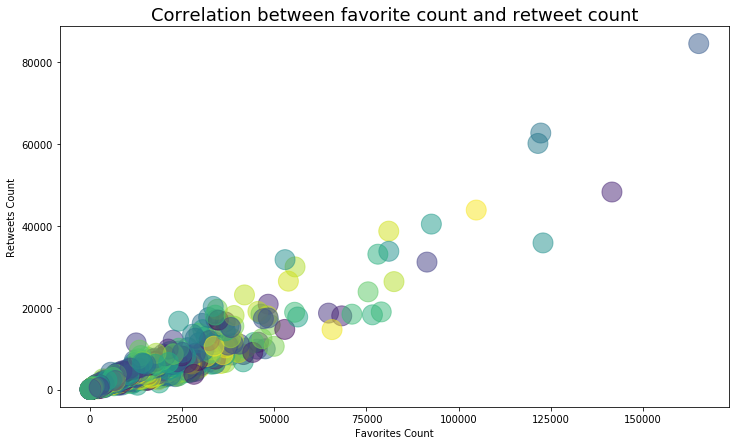

In [92]:
N=clean_master_df.shape[0]
colors = np.random.rand(N)
area = 20**2 

rcParams['figure.figsize'] = 12, 7

plt.scatter(clean_master_df['favorite_count'], clean_master_df['retweet_count'], s=area, c=colors, alpha=0.5)
plt.xlabel('Favorites Count')
plt.ylabel('Retweets Count')
plt.title('Correlation between favorite count and retweet count', fontsize=18)
plt.show()

Also I will use pearson correlation coefficient to check the correlation values between the same two variables as shown in the following code cell.

In [93]:
np.corrcoef(clean_master_df['favorite_count'], clean_master_df['retweet_count'])

array([[ 1.        ,  0.92903852],
       [ 0.92903852,  1.        ]])

Reffering to the scatter plot in above and the results of the pearson correlation coefficients (0.929), There is a strong positive correlation between the "favorite_count" variable and "retweet_count" variable. The scatter plot for the relation shows a linear relationship between the two variables.

I will explore the most popular dogs based on the number of retweets using "retweet_count" variable. In the following code cell, I will pick the most popular eight dogs based on that criteria.

In [94]:
# first, we will get the highest 10 values for the retweet count in our dataset
top_8_retweet_count = clean_master_df['retweet_count'].nlargest(8, keep='first')

# filter the dataframe to get only the records with the highest 8 retweets count in the dataset
most_popular_dogs_df = clean_master_df[clean_master_df['retweet_count'].isin(top_8_retweet_count)]

# Sort the results descendingly by "retweet_count" field
most_popular_dogs_df = most_popular_dogs_df.sort_values(by=['retweet_count'], ascending=False)

most_popular_dogs_df

,tweet_id,name,stage,rating_numerator,rating_denominator,date,time,full_text,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
774,744234799360020481,None,doggo,13.0,10.0,2016-06-18,18:26:18,Here's a doggo realizing you can stand in a po...,165056,84452,...,1,Labrador Retriever,0.825333,True,Ice Bear,0.044681,False,Whippet,0.018442,True
809,739238157791694849,None,doggo,13.0,10.0,2016-06-04,23:31:25,Here's a doggo blowing bubbles. It's downright...,122244,62617,...,1,Eskimo Dog,0.503372,True,Siberian Husky,0.390413,True,Malamute,0.080901,True
400,807106840509214720,Stephan,pupper,13.0,10.0,2016-12-09,06:17:20,This is Stephan. He just wants to help. 13/10 ...,121479,60076,...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,Toy Terrier,0.077008,True
309,822872901745569793,None,puppo,13.0,10.0,2017-01-21,18:26:02,Here's a super supportive puppo participating ...,141536,48220,...,1,Lakeland Terrier,0.196015,True,Labrador Retriever,0.160329,True,Irish Terrier,0.069126,True
58,879415818425184262,Duddles,pupper,13.0,10.0,2017-06-26,19:07:24,This is Duddles. He did an attempt. 13/10 some...,104754,43816,...,1,English Springer,0.383404,True,Boston Bull,0.134967,True,Cardigan,0.110481,True
333,819004803107983360,Bo,doggo,14.0,10.0,2017-01-11,02:15:36,This is Bo. He was a very good First Doggo. 14...,92590,40390,...,1,Standard Poodle,0.351308,True,Toy Poodle,0.271929,True,Tibetan Terrier,0.094759,True
402,806629075125202948,None,pupper,13.0,10.0,2016-12-07,22:38:52,"""Good afternoon class today we're going to lea...",81044,38666,...,2,Arabian Camel,0.366248,False,House Finch,0.209852,False,Cocker Spaniel,0.046403,True
108,866450705531457537,Jamesy,pupper,13.0,10.0,2017-05-22,00:28:40,This is Jamesy. He gives a kiss to every other...,122851,35794,...,2,French Bulldog,0.905334,True,Boston Bull,0.078060,True,Pug,0.001771,True


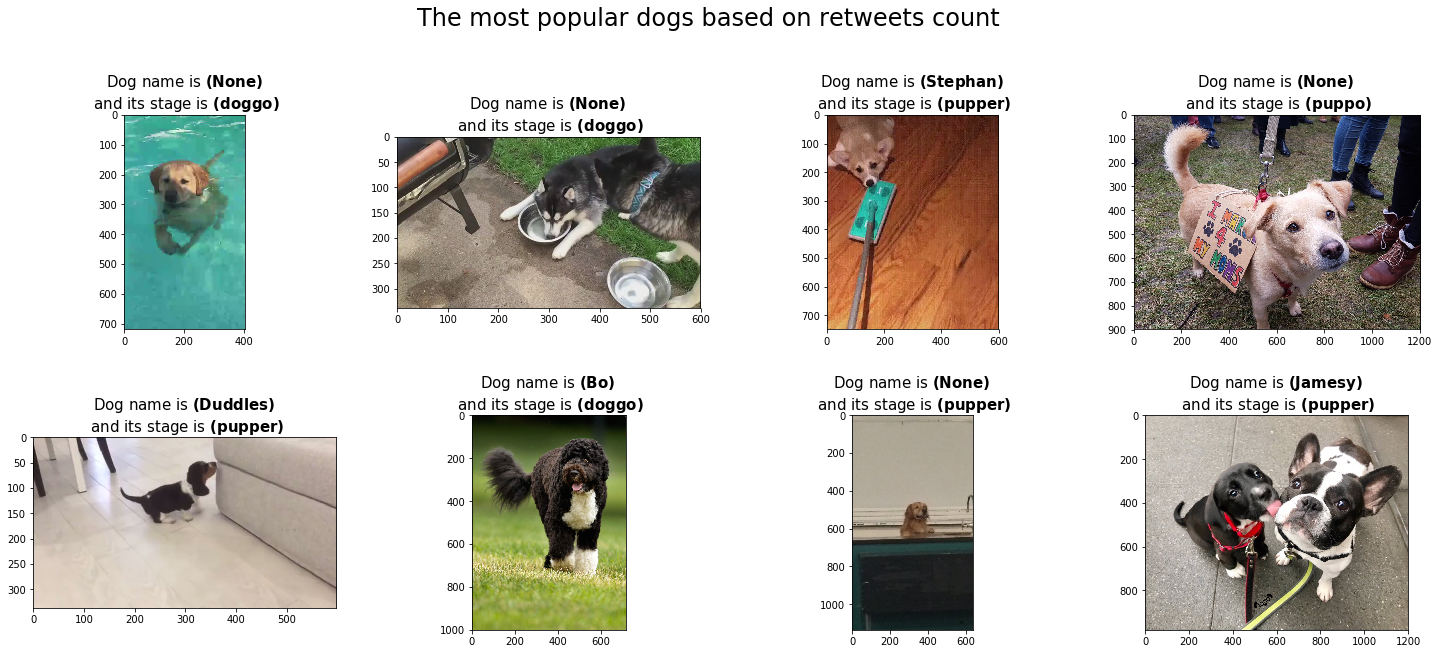

In [95]:
# Now I'm curious to see how the top popular dogs look like, so let's display their images

fig = plt.figure(figsize=(25,15))
fig.suptitle("The most popular dogs based on retweets count", fontsize=24)
columns = 4
idx = 0
fig.subplots_adjust(hspace=0.4)

for i, row in most_popular_dogs_df.iterrows():
    img_url = row['jpg_url']
    dog_desc = 'Dog name is '+ r"$\bf{("+ row['name'] + ')}$ \n and its stage is '+ r"$\bf{("+ str(row['stage']) +')}$'
    image = io.imread(img_url)
    plt.subplot(most_popular_dogs_df.shape[0] / columns + 1, columns, idx + 1)
    plt.title(dog_desc, fontsize=15)
    plt.imshow(image)
    idx += 1

These results are also another evidence how strong the linear relationship between the favorite count and the retweet count is; most of the most liked dogs are also the most popular ones.

As part of the data analysis and visualization process, I will also explore the distribution of the dog breeds predicted by the deep neural network model. In that analysis, I will take into account two main factors; the predicted label from the first most likely prediction (p1) and whether this label is a dog breed or not "p1_dog". I choose these two variables to be more confident about the results and get more reliable conclusions.

In [96]:
# filter the dataframe with the dogs which have highly confident dog breed label.
dogs_with_breeds_df = clean_master_df[(clean_master_df['p1_dog'] == True)]

# Get quick descriptive statistics about the predicted dog breeds
dogs_with_breeds_df['p1'].describe()

count                 1476
unique                 111
top       Golden Retriever
freq                   139
Name: p1, dtype: object

In [97]:
# Get the most common predicted 30 dog breeds in our dataset

most_common_breeds = Counter(dogs_with_breeds_df['p1']).most_common(30)

common_breeds_df = pd.DataFrame(data=most_common_breeds, columns=['dog_breed', 'frequency'])

common_breeds_df

,dog_breed,frequency
0,Golden Retriever,139
1,Labrador Retriever,95
2,Pembroke,88
3,Chihuahua,79
4,Pug,54
5,Chow,41
6,Samoyed,40
7,Pomeranian,38
8,Toy Poodle,38
9,Malamute,29


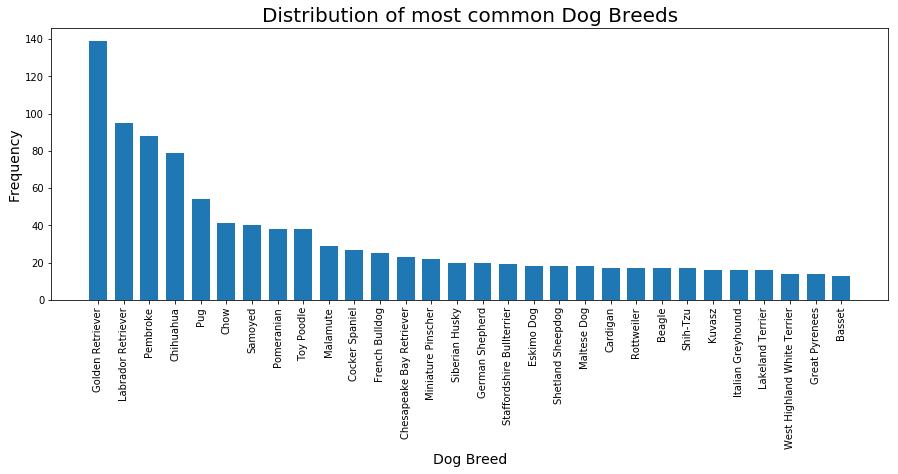

In [98]:
# plot a bar chart of these most common 30 dog breeds to visualize the frequencies of each dog breed in the dataset

rcParams['figure.figsize'] = 15, 5 

indexes = np.arange(common_breeds_df.shape[0])

plt.bar(indexes, common_breeds_df['frequency'], align='edge', width=0.7)

plt.xticks(indexes + 0.7 * 0.5, common_breeds_df['dog_breed'], rotation=90)
plt.title('Distribution of most common Dog Breeds', fontsize=20)
plt.xlabel('Dog Breed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
    
plt.show()

From the visualizations above, Golden Retriever is the most common dog breed predicted for our dogs in the dataset with 139 instances.

Let's look at the rating score by considering the two fields "rating_numerator & rating_denominator". As rating system in "WeRateDogs" allows numerators to be bigger than "10", but these ratings almost always have a denominator of 10. Looking back at our rating denominators in the dataset, we can recognize there are few observations with denominators less or greater than 10. Let's find out these observations.


In [99]:
excluded_rating_outliers = clean_master_df.query('rating_denominator != 10')

excluded_rating_outliers

,tweet_id,name,stage,rating_numerator,rating_denominator,date,time,full_text,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
323,820690176645140481,None,doggo,84.0,70.0,2017-01-15,17:52:40,The floofs have been released I repeat the flo...,13062,3551,...,2,West Highland White Terrier,0.872064,True,Kuvasz,0.059526,True,Samoyed,0.037400,True
385,810984652412424192,Sam,pupper,24.0,7.0,2016-12-19,23:06:23,Meet Sam. She smiles 24/7 &amp; secretly aspir...,5740,1583,...,1,Golden Retriever,0.871342,True,Tibetan Mastiff,0.036708,True,Labrador Retriever,0.025823,True
662,758467244762497024,None,doggo,165.0,150.0,2016-07-28,01:00:57,Why does this never happen at my front door......,5133,2430,...,1,Labrador Retriever,0.436377,True,Chihuahua,0.113956,True,American Staffordshire Terrier,0.099689,True
799,740373189193256964,None,pupper,9.0,11.0,2016-06-08,02:41:38,"After so many requests, this is Bretagne. She ...",36734,14345,...,3,Golden Retriever,0.807644,True,Kuvasz,0.101286,True,Labrador Retriever,0.023785,True
847,731156023742988288,Solomon,doggo,204.0,170.0,2016-05-13,16:15:54,Say hello to this unbelievably well behaved sq...,4048,1366,...,1,Lakeside,0.501767,False,Breakwater,0.051351,False,King Penguin,0.049444,False
890,722974582966214656,None,pupper,4.0,20.0,2016-04-21,02:25:47,Happy 4/20 from the squad! 13/10 for all https...,4329,1687,...,1,Great Dane,0.246762,True,Greater Swiss Mountain Dog,0.126131,True,Weimaraner,0.085297,True
924,716439118184652801,Bluebert,pupper,50.0,50.0,2016-04-03,01:36:11,This is Bluebert. He just saw that both #Final...,2484,230,...,1,Siberian Husky,0.396495,True,Malamute,0.317053,True,Eskimo Dog,0.273419,True
945,713900603437621249,None,doggo,99.0,90.0,2016-03-27,01:29:02,Happy Saturday here's 9 puppers on a bench. 99...,2981,800,...,1,Golden Retriever,0.371816,True,Cocker Spaniel,0.177413,True,Irish Setter,0.092725,True
969,710658690886586372,None,pupper,80.0,80.0,2016-03-18,02:46:49,Here's a brigade of puppers. All look very pre...,2432,606,...,1,Soft-Coated Wheaten Terrier,0.948617,True,Dandie Dinmont,0.018664,True,Cairn,0.015943,True
987,709198395643068416,None,pupper,45.0,50.0,2016-03-14,02:04:08,"From left to right:\nCletus, Jerome, Alejandro...",2544,687,...,1,Borzoi,0.490783,True,Wire-Haired Fox Terrier,0.083513,True,English Setter,0.083184,True


As we can see, there are 18 observations that have rating denominators less or greater than 10.

For the sake of rating scores analysis and to get more precious results about the rating scores part, I will introduce a new temporary field in our dataframe and I will call it "rating_score" field, in this field, I will store the rating score resulted from the division of the rating numerator and the rating denominator after excluding the 18 observations that have denominators smaller or greater than 10.

In [100]:
rating_denominator_idx = clean_master_df.columns.get_loc('rating_denominator')

column_name = 'rating_score'

rating_score_idx = rating_denominator_idx + 1

clean_proper_rating_df = clean_master_df.copy()

clean_proper_rating_df = clean_proper_rating_df.query('rating_denominator == 10')

clean_proper_rating_df.insert(rating_score_idx, column_name, round(np.divide(clean_proper_rating_df['rating_numerator'], 
                                                                clean_proper_rating_df['rating_denominator']),2))
clean_proper_rating_df.head()

,tweet_id,name,stage,rating_numerator,rating_denominator,rating_score,date,time,full_text,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,Phineas,NaN,13.0,10.0,1.3,2017-08-01,16:23:56,This is Phineas. He's a mystical boy. Only eve...,38331,...,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,Tilly,NaN,13.0,10.0,1.3,2017-08-01,00:17:27,This is Tilly. She's just checking pup on you....,32855,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,Archie,NaN,12.0,10.0,1.2,2017-07-31,00:18:03,This is Archie. He is a rare Norwegian Pouncin...,24745,...,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,Darla,NaN,13.0,10.0,1.3,2017-07-30,15:58:51,This is Darla. She commenced a snooze mid meal...,41671,...,1,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,Franklin,NaN,12.0,10.0,1.2,2017-07-29,16:00:24,This is Franklin. He would like you to stop ca...,39848,...,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True


In [101]:
# get a descriptive statistics about the rating score series

clean_proper_rating_df['rating_score'].describe()

count    1975.000000
mean        1.169823
std         4.086159
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating_score, dtype: float64

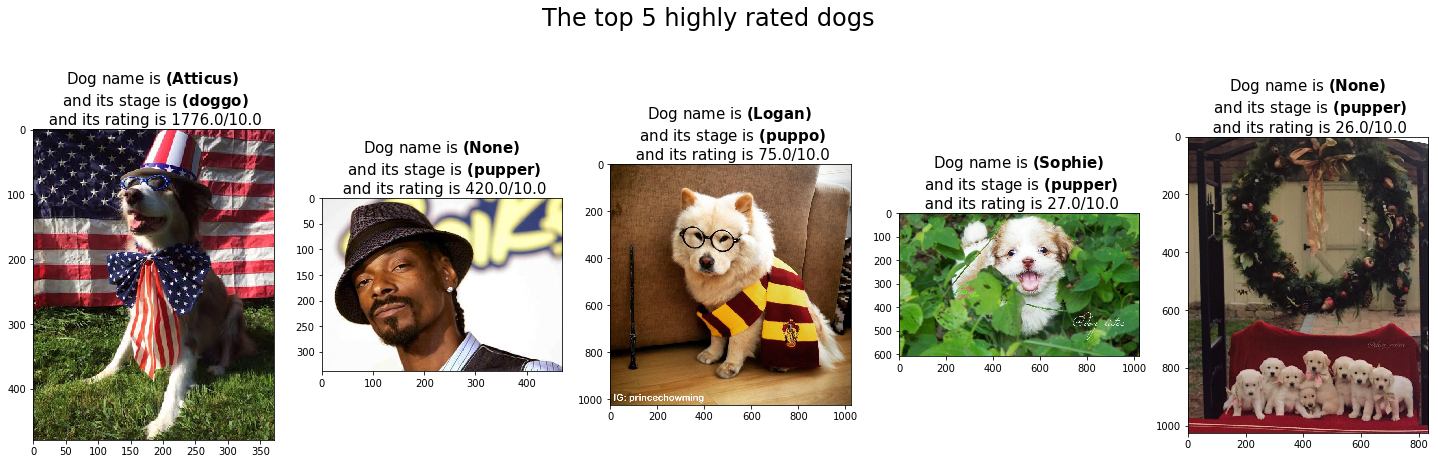

In [102]:
# get the top 5 highly rated dogs based on the rating score and display their images 
#to view how these highly rated dogs look like

top_5_ratings = clean_proper_rating_df['rating_score'].nlargest(5, keep='first')

top_rated_dogs_df = clean_proper_rating_df[clean_proper_rating_df['rating_score'].isin(top_5_ratings)]

tope_rated_sorted_df = top_rated_dogs_df.sort_values(by='rating_score', ascending=False)

fig = plt.figure(figsize=(25,15))
fig.suptitle("The top 5 highly rated dogs", fontsize=24)
columns = 5
idx = 0
fig.subplots_adjust(hspace=0.4)

for i, row in tope_rated_sorted_df.iterrows():
    img_url = row['jpg_url']
    dog_rating = str(row['rating_numerator']) + '/'+ str(row['rating_denominator'])
    dog_desc = 'Dog name is '+ r"$\bf{("+ row['name'] + ')}$ \n and its stage is '+ r"$\bf{("+ str(row['stage']) +')}$'
    dog_desc += '\n and its rating is '+ dog_rating
    image = io.imread(img_url)
    plt.subplot(tope_rated_sorted_df.shape[0] / columns + 1, columns, idx + 1)
    plt.title(dog_desc, fontsize=15)
    plt.imshow(image)
    idx += 1

As we can notice, the second highly rated image is not a dog and it got 420/10. The other images are awesome dogs and they got a high rating score, especially the first dog (1776/10)

In [103]:
# Check the pearson correlation coefficient between the rating score and the favorite count variables
print('Correlation between the rating score and the favorite count variables: \n')
print(np.corrcoef(clean_proper_rating_df['favorite_count'], clean_proper_rating_df['rating_score']))

# Check the pearson correlation coefficient between the rating score and the favorite count variable
print('\n =======================================================================\n')
print('\n Correlation between the rating score and the retweet count variables \n')
print(np.corrcoef(clean_proper_rating_df['retweet_count'], clean_proper_rating_df['rating_score']))

Correlation between the rating score and the favorite count variables: 

[[ 1.          0.02195302]
 [ 0.02195302  1.        ]]



 Correlation between the rating score and the retweet count variables 

[[ 1.          0.02298145]
 [ 0.02298145  1.        ]]


From the results above, there is no correlation between the rating score and favorite count or the retweets count, the correlation values for both of them (0.0219 and 0.02298) respectively.

The same conclusion about the correlation between the rating score and retweets count can be visualized in the following scatter plot, which shows evidently no correlation or relationship between the two variables.

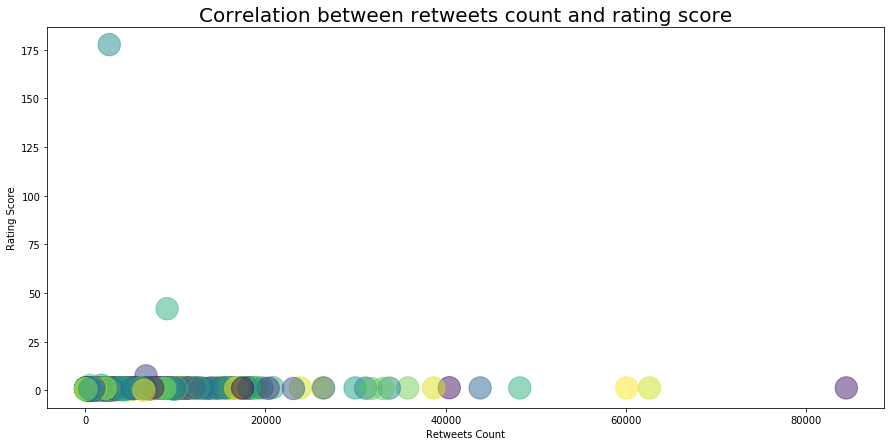

In [104]:
N=clean_proper_rating_df.shape[0]
colors = np.random.rand(N)
area = 500 

rcParams['figure.figsize'] = 15, 7

plt.scatter(clean_proper_rating_df['retweet_count'], clean_proper_rating_df['rating_score'], s=area, c=colors, alpha=0.5)
plt.xlabel('Retweets Count')
plt.ylabel('Rating Score')
plt.title('Correlation between retweets count and rating score', fontsize=20)
plt.show()